# Бинарная регрессия
Для начала заимпортим всё что нам может понадобиться

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

Посмотрим на данные

In [2]:
df = pd.read_excel('telco.xls', index_col=0)
df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,reside,...,equipmon,cardmon,wiremon,multline,voice,internet,callid,callwait,forward,confer
region,,,,,,,,,,,,,,,,,,,,,
Zone 2,13,44,Married,9,64,College degree,5,No,Male,2,...,0.0,7.50,0.0,No,No,No,No,No,Yes,No
Zone 3,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,6,...,0.0,15.25,35.7,No,Yes,No,Yes,Yes,Yes,Yes
Zone 3,68,52,Married,24,116,Did not complete high school,29,No,Female,2,...,0.0,30.25,0.0,No,No,No,Yes,Yes,No,Yes
Zone 2,33,33,Unmarried,12,33,High school degree,0,No,Female,1,...,0.0,0.00,0.0,No,No,No,No,No,No,No
Zone 2,23,30,Married,9,30,Did not complete high school,2,No,Male,4,...,0.0,0.00,0.0,No,No,No,Yes,No,Yes,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, Zone 2 to Zone 3
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    1000 non-null   int64  
 1   age       1000 non-null   int64  
 2   marital   1000 non-null   object 
 3   address   1000 non-null   int64  
 4   income    1000 non-null   int64  
 5   ed        1000 non-null   object 
 6   employ    1000 non-null   int64  
 7   retire    1000 non-null   object 
 8   gender    1000 non-null   object 
 9   reside    1000 non-null   int64  
 10  tollfree  1000 non-null   object 
 11  equip     1000 non-null   object 
 12  callcard  1000 non-null   object 
 13  wireless  1000 non-null   object 
 14  longmon   1000 non-null   float64
 15  tollmon   1000 non-null   float64
 16  equipmon  1000 non-null   float64
 17  cardmon   1000 non-null   float64
 18  wiremon   1000 non-null   float64
 19  multline  1000 non-null   object 
 20  voice     1000 non-null   ob

In [4]:
# Названия переменных, сгруппированные по типам данных
for t in df.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: int64
['tenure' 'age' 'address' 'income' 'employ' 'reside']

Type: object
['marital' 'ed' 'retire' 'gender' 'tollfree' 'equip' 'callcard' 'wireless'
 'multline' 'voice' 'internet' 'callid' 'callwait' 'forward' 'confer']

Type: float64
['longmon' 'tollmon' 'equipmon' 'cardmon' 'wiremon']



In [5]:
# Процент пропущенных значений по переменным, содержащим пропуски
missing = (df.isna().sum() / len(df)) * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing = pd.DataFrame({'Процент пропущенных значений' : missing})
missing

# ура, нет пропусков!

,Процент пропущенных значений


## Выбор переменных
Зависимая переменная: `forward` - Пользуется ли клиент услугой переадресации звонка (Yes, No)

Обязательные предикторы:
- age - Возраст клиента в годах
- marital - Семейное положение клиента (Unmarried, Married)
- reside - Количество человек в семье клиента
- retire - Находится ли клиент на пенсии? (No, Yes)
- employ - Число лет работы клиента у текущего работодателя (в индивидуальном задании чуть другое название переменной, но её нет в описании переменных)

И нужно ещё 3+ выбрать, допустим
- tenure - Число месяцев использования клиентом сервисов компании
- address - Число лет проживания клиента по текущему адресу
- income - Доход семьи клиента в тысячах у.е.
- cardmon - Длительность пользования телефонной картой в прошлом месяце (в минутах)

думаю, они могут влиять на таргет


### Предварительный анализ взаимосвязей между зависимой переменной и предикторами

In [6]:
df['forward'].value_counts()

forward
No     507
Yes    493
Name: count, dtype: int64

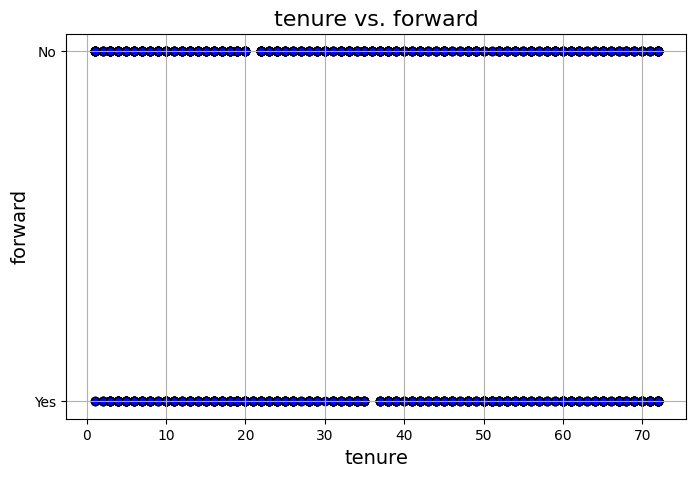

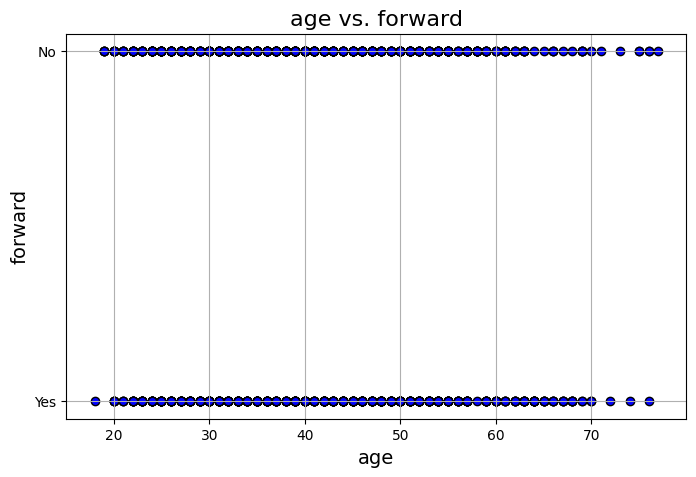

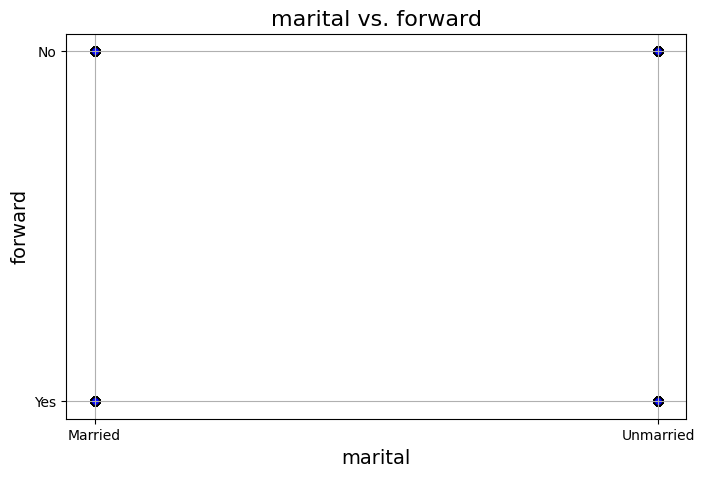

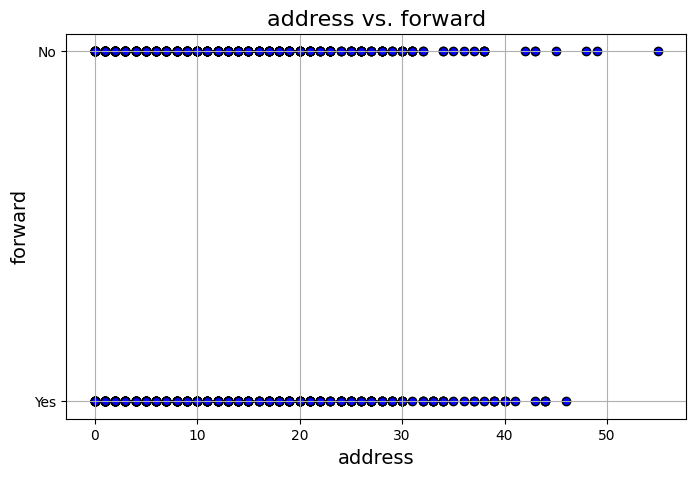

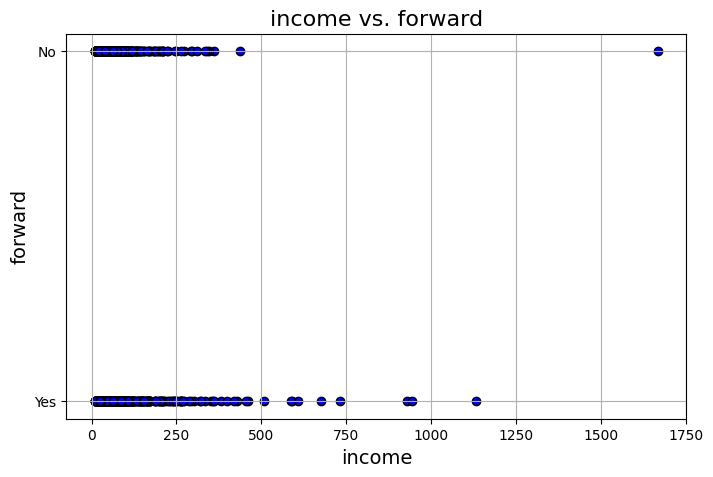

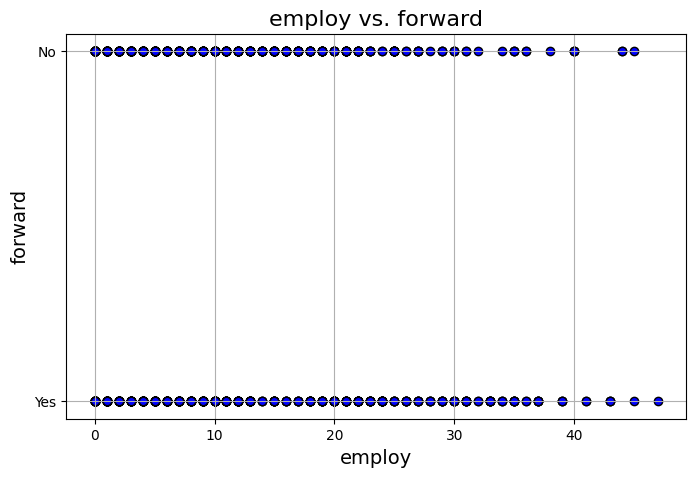

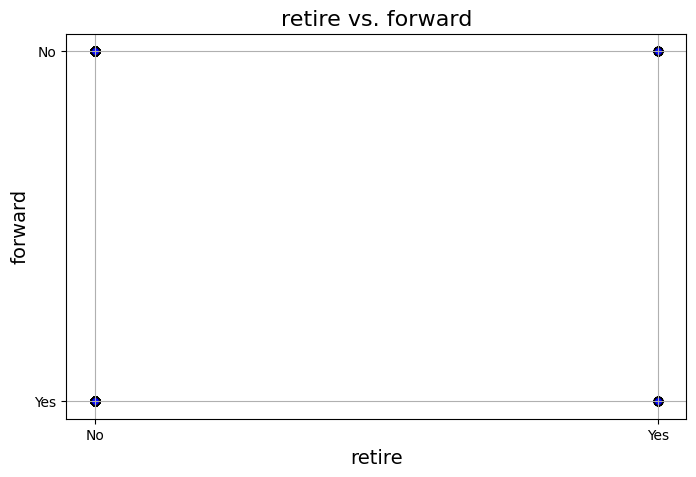

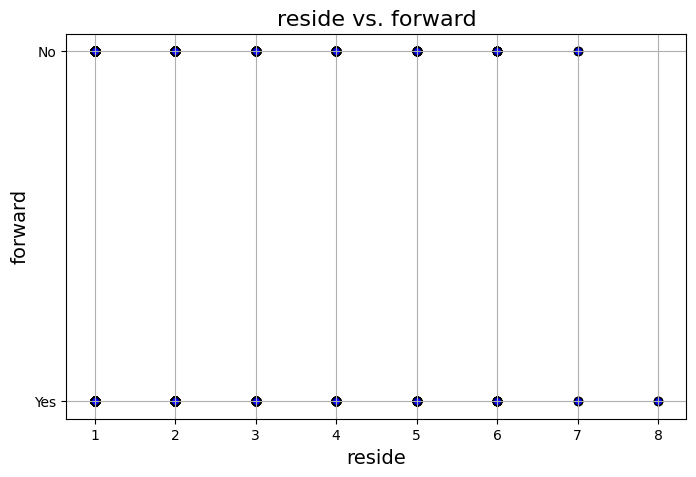

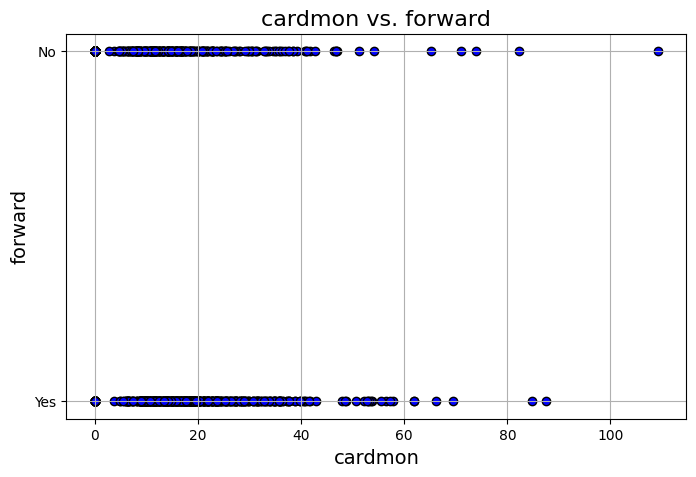

In [7]:
for c in df.columns[:]:
    if c == 'age' or c == 'marital' or c=='reside' or c=='retire' or c=='employ' or c=='tenure' or c=='address' or c=='income' or c=='cardmon':
        plt.figure(figsize=(8,5))
        plt.title('{} vs. forward'.format(c), fontsize=16)
        plt.scatter(x=df[c], y=df['forward'], color='blue',edgecolor='k')
        plt.grid(True)
        plt.xlabel(c, fontsize=14)
        plt.ylabel('forward', fontsize=14)
        plt.show()

<font color='red'>так себе выбор типа графика, не наглядно </font>

по всем данным есть значения

In [8]:
# закодируем категориальные переменные с двумя возможными значениями
df['forward'] = df['forward'].map({'Yes': 1, 'No': 0})
df['marital'] = df['marital'].map({'Unmarried': 0, 'Married' : 1})
df['retire'] = df['retire'].map({'Yes': 1, 'No': 0})

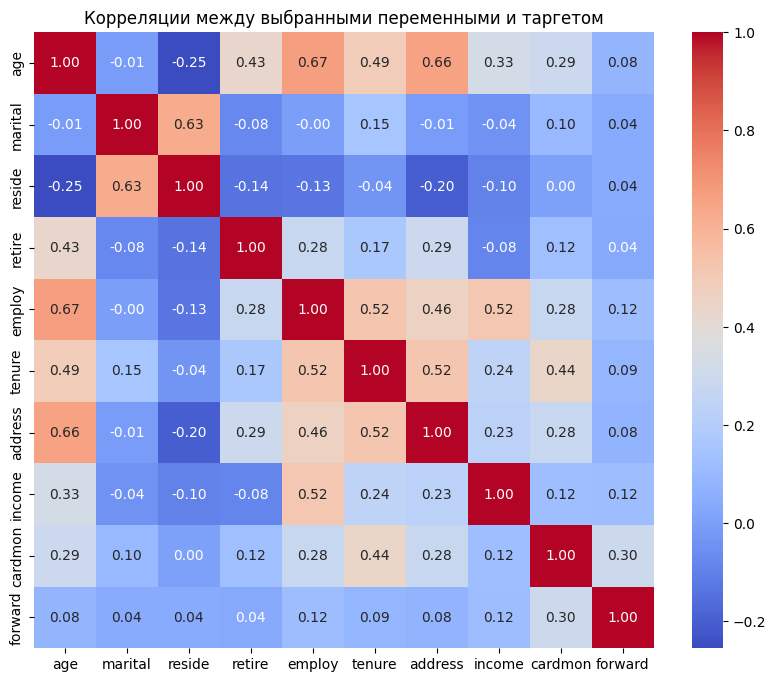

In [9]:
# Построим хитмап корреляций между выбранными переменными и таргетом

selected_features = ['age', 'marital', 'reside', 'retire', 'employ', 'tenure', 'address', 'income', 'cardmon', 'forward']
corr_matrix = df[selected_features].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляции между выбранными переменными и таргетом')
plt.show()

каких-то больших корреляций нет, самая большая - 0,67 между age и employ, но эти переменные надо было обязательно брать, так что норм

<font color='red'> 66-67 довольно интересные</font>

## Строим модель

In [10]:
x_mult = df[['age', 'marital', 'reside', 'retire', 'employ', 'tenure', 'address', 'income', 'cardmon']]
y = df['forward']
x_mult_constant = sm.add_constant(x_mult)

In [11]:
model1 = sm.Logit(y, x_mult_constant).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.635290
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                forward   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      990
Method:                           MLE   Df Model:                            9
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:                 0.08334
Time:                        21:24:21   Log-Likelihood:                -635.29
converged:                       True   LL-Null:                       -693.05
Covariance Type:            nonrobust   LLR p-value:                 1.102e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5985      0.340     -1.759      0.079      -1.265       0.068
age           -0.0075      0.

чота плохо получилось, видимо переменные надо было лучше выбирать, переделаем

<font color='red'> )))</font>

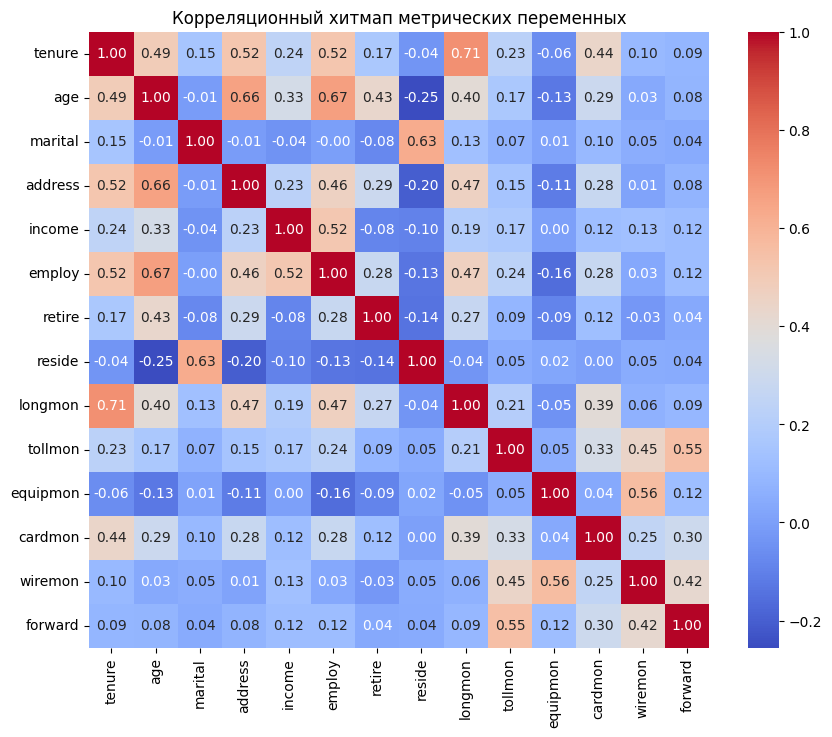

In [12]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционный хитмап метрических переменных')
plt.show()


Возьмём tollmon, wiremon, cardmon - у них самые большие корреляции с forward. tenure, address и income уберём

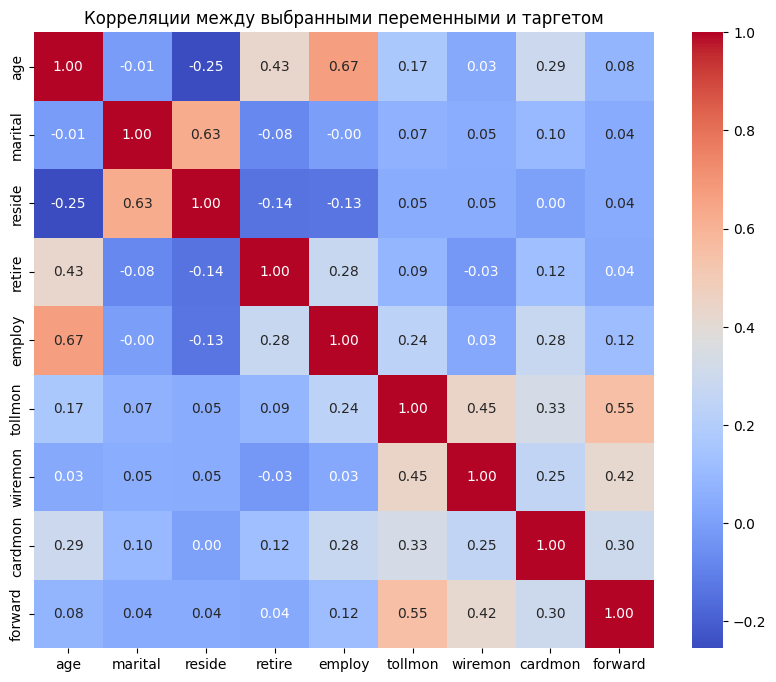

In [13]:
# Построим хитмап корреляций между выбранными переменными и таргетом (на всякий случай)

selected_features = ['age', 'marital', 'reside', 'retire', 'employ', 'tollmon', 'wiremon', 'cardmon', 'forward']
corr_matrix = df[selected_features].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляции между выбранными переменными и таргетом')
plt.show()

Гипотезы
- H0: 'age' влияет на 'forward'
- H1: 'age' не влияет на таргет
---

- H0: 'marital' влияет на 'forward'
- H1: 'marital' не влияет на таргет
---
- H0: 'reside' влияет на 'forward'
- H1: 'reside' не влияет на таргет
---

- H0: 'retire' влияет на 'forward'
- H1: 'retire' не влияет на таргет
---
- H0: 'employ' влияет на 'forward'
- H1: 'employ' не влияет на таргет
---

- H0: 'tollmon' влияет на 'forward'
- H1: 'tollmon' не влияет на таргет
---

- H0: 'wiremon' влияет на 'forward'
- H1: 'wiremon' не влияет на таргет

---
- H0: 'cardmon' влияет на 'forward'
- H1: 'cardmon' не влияет на таргет


## Строим модель

In [14]:
x_mult = df[['age', 'marital', 'reside', 'retire', 'employ', 'tollmon', 'wiremon', 'cardmon']]
y = df['forward']
x_mult_constant = sm.add_constant(x_mult)

In [15]:
model1 = sm.Logit(y, x_mult_constant).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.460525
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                forward   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            8
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:                  0.3355
Time:                        21:24:22   Log-Likelihood:                -460.52
converged:                       True   LL-Null:                       -693.05
Covariance Type:            nonrobust   LLR p-value:                 2.202e-95
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5707      0.402     -3.904      0.000      -2.359      -0.782
age           -0.0053      0.

## Оценка построенной моедели

### Комментарии к выводу модели

Current function value: 0.460525.
Это значение функции логарифмической правдоподобности на последней итерации. Чем меньше оно, тем лучше модель описывает данные. В нашем случае значение достаточно низкое, что говорит о неплохой подгонке модели.

---
Pseudo R-squared: 0.3355.
Значение 0.3355 указывает на умеренную объяснительную способность модели – модель объясняет примерно 33.6% вариации зависимой переменной.

---
Log-Likelihood: -460.52. Это значение логарифма правдоподобия для модели с предикторами.

---
LL-Null: -693.05. Это логарифм правдоподобия модели, в которой учтена только константа (без предикторов). Разница между ними демонстрирует, насколько добавление предикторов улучшило модель.

---
LLR p-value: 2.202e-95.
Очень маленькое значение p свидетельствует о том, что модель с предикторами значительно лучше, чем модель, содержащая только константу.



Интерпретация предикторов

Age (коэффициент = –0.0053, p = 0.586):
exp(−0.0053)≈0.9947
Увеличение возраста на 1 год снижает шансы положительного исхода примерно на 0.53%, но данный эффект не является статистически значимым (p > 0.05).

Marital (коэффициент = –0.0377, p = 0.862):
exp(−0.0377)≈0.963
Изменение семейного положения (например, с Unmarried на Married) практически не влияет на вероятность положительного исхода. Но p > 0.05

Reside (коэффициент = 0.0528, p = 0.504):
exp(0.0528)≈1.054
Каждая единица увеличения данного показателя (например, увеличение числа членов семьи или другой метрики, связанной с проживанием) повышает шансы положительного исхода примерно на 5.4%, однако эффект статистически незначим.

Retire (коэффициент = –0.0131, p = 0.977):
exp(−0.0131)≈0.987
Факт нахождения на пенсии почти не изменяет шансы положительного исхода. Эффект статистически незначим

Employ (коэффициент = 0.0007, p = 0.949):
exp(0.0007)≈1.0007
Изменение стажа работы у текущего работодателя не оказывает значимого влияния. Эффект статистически незначим

Tollmon (коэффициент = 0.0891, p < 0.001):
exp(0.0891)≈1.093
Каждая дополнительная минута использования услуги "Toll free service" повышает логит шансов, что соответствует увеличению шансов положительного исхода примерно на 9.3%.

Wiremon (коэффициент = 0.0374, p < 0.001):
exp(0.0374)≈1.038
Каждая дополнительная минута использования беспроводных сервисов увеличивает шансы положительного исхода на примерно 3.8%.

Cardmon (коэффициент = 0.0220, p = 0.001):
exp(0.0220)≈1.022
Увеличение времени использования телефонной карты на 1 минуту связано с ростом шансов положительного исхода примерно на 2.2%.

Константа (const = –1.5707, p < 0.001):
Этот параметр задаёт базовый уровень логитов, когда все предикторы равны нулю. Хотя константа сама по себе не интерпретируется с точки зрения влияния на исход, она служит отправной точкой для расчёта вероятности

In [16]:
print('Model significance = {:f}'.format(model1.llr_pvalue))

Model significance = 0.000000


In [17]:
l = []
for (param, index) in zip(model1.params[1:], model1.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))

print('logit(p) = {:2f} + {}'.format(model1.params[0], ' + '.join(l)))

logit(p) = -1.570689 + -0.01*age + -0.04*marital + 0.05*reside + -0.01*retire + 0.00*employ + 0.09*tollmon + 0.04*wiremon + 0.02*cardmon


### Матрица ошибок

In [18]:
cm = model1.pred_table()
cm

array([[430.,  77.],
       [112., 381.]])

In [19]:
accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm))
print('Точность (процент верно предсказанных событий): = {}'.format(accuracy))

Точность (процент верно предсказанных событий): = 0.811


### ROC-curve

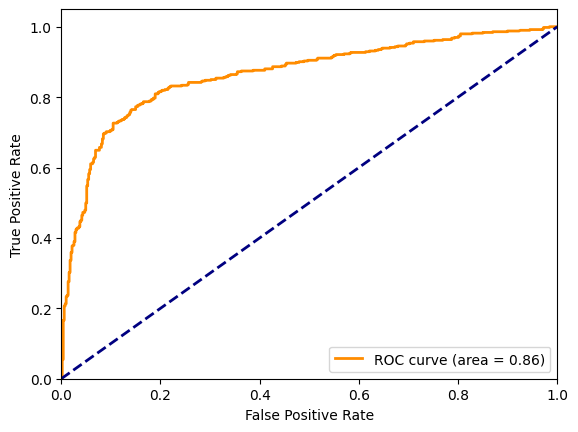

In [20]:
fpr, tpr, _ = roc_curve(df['forward'], model1.predict())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

0.86 довольно близко к 1, что говорит о том, что у нас хорошая модель

In [21]:
p = stats.kstest(model1.resid_generalized, 'norm', args=(model1.resid_generalized.mean(), model1.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


<Axes: ylabel='Density'>

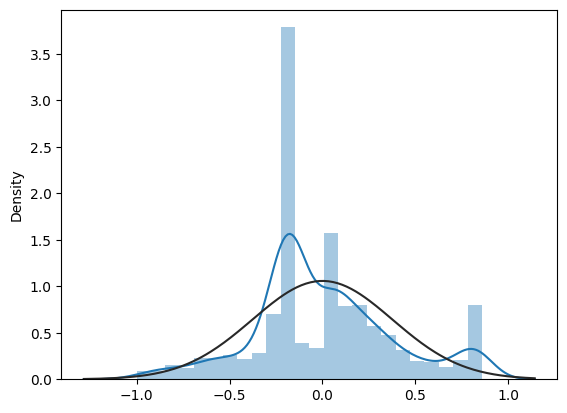

In [22]:
sns.distplot(model1.resid_generalized, fit=stats.norm)
# Распределение остатков отличается от нормального распределения.

In [23]:
vifs = np.array([vif(model1.model.exog, i) for i in range(model1.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model1.params.index[1:]
vif_df.sort_values(by=['VIF'])

# Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует.

,VIF,Features
3,1.240148,retire
7,1.241298,cardmon
6,1.291162,wiremon
5,1.388409,tollmon
1,1.729160,marital
2,1.838296,reside
4,1.894332,employ
0,2.255003,age


## Общие содержательные выводы
### Интерпретация значимых эффектов
Наиболее значимыми предикторами оказались переменные, отражающие активное использование услуг компании (tollmon, wiremon, cardmon). Каждая дополнительная минута использования этих сервисов существенно увеличивает шансы положительного исхода. Это указывает на то, что клиенты, активно пользующиеся определёнными услугами, вероятнее всего воспользуются и услугой переадресации звонков.

### Роль демографических и социальных переменных
Демографические характеристики (возраст, семейное положение, пенсионный статус, стаж работы) не продемонстрировали статистически значимого влияния на вероятность положительного исхода. Это может быть несколько неожиданным, так как часто предполагается, что базовые характеристики клиентов могут влиять на их поведение. Однако результат говорит о том, что в данном случае ключевым фактором являются именно параметры активности, связанные с использованием сервисов.

### Диагностика модели
Проверка мультиколлинеарности с помощью VIF и корреляционной матрицы показывает, что предикторы не слишком сильно коррелируют друг с другом, что позволяет считать модель устойчивой и корректно интерпретируемой.


## Общие выводы
Результаты анализа подтверждают, что для прогноза положительного исхода (использование услуги forward) главным образом важны показатели, отражающие активность клиентов в использовании телекоммуникационных сервисов. Демографические и социальные характеристики, возможно, не играют решающую роль в данном контексте. Такие результаты дают практическую основу для фокусировки маркетинговых и операционных стратегий на сегментах клиентов, активно пользующихся конкретными услугами, а не на сегментации по базовым демографическим характеристикам.

# Анализ временного ряда

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


df = pd.read_excel('sberbank-moscow-exchange.xlsx')
df.head()

,Дата,Цена открытия,Минимальная цена,Максимальная цена,Цена закрытия,Средняя цена,Количество сделок
0,15.03.2024,295.71,295.29,299.44,298.30,297.98,54631
1,14.03.2024,298.50,295.14,298.70,295.83,296.75,113582
2,13.03.2024,301.20,298.70,301.49,298.85,299.95,53415
3,12.03.2024,299.60,297.34,301.07,300.90,299.47,78941
4,11.03.2024,301.00,298.50,302.95,299.79,300.94,102433


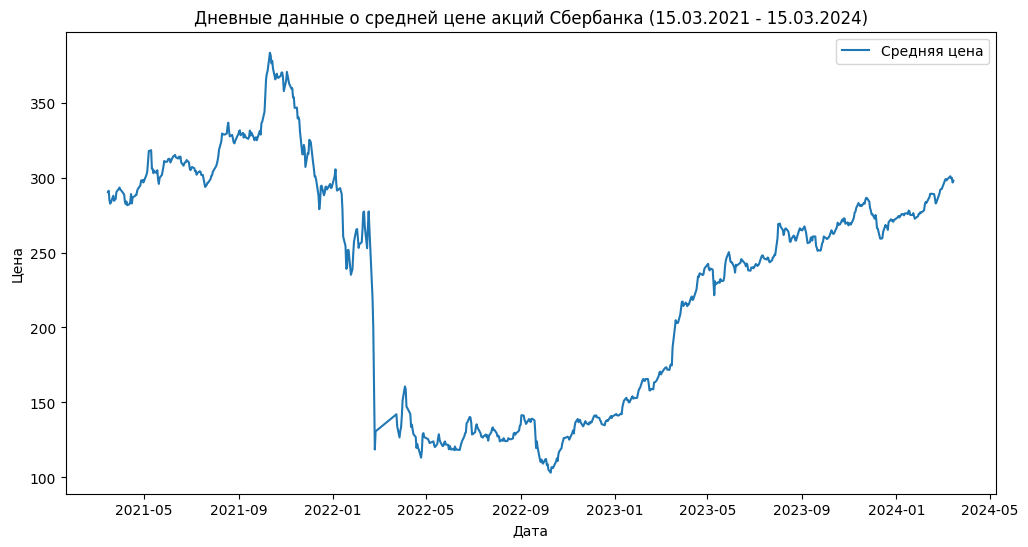

In [25]:
df = pd.read_excel('sberbank-moscow-exchange.xlsx', parse_dates=['Дата'])

start_date = '15.03.2021'
end_date = '15.03.2024'
mask = (df['Дата'] >= start_date) & (df['Дата'] <= end_date)
df = df.loc[mask]

# Оставляем только столбцы 'Дата' и 'Средняя цена'
dff = df[['Дата', 'Средняя цена']].copy()

dff.set_index('Дата', inplace=True)

# Построение графика временного ряда по переменной "Средняя цена"
plt.figure(figsize=(12, 6))
plt.plot(dff['Средняя цена'], label='Средняя цена')
plt.title('Дневные данные о средней цене акций Сбербанка (15.03.2021 - 15.03.2024)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()


Видим, что где-то в декабре 2021 года цена начала падать, очень сильно упала и была примерно на одном уровне до зимы 2023 года, потом потихоньку начала расти и к маю 2024 восстановилась - цена примерно такая же, как в мае 2021. Вряд ли тут сезонность какая-то, просто событие одно произошло и цена рухнула. А так тренд восходящий

In [26]:
print("Количество пропусков:", dff['Средняя цена'].isnull().sum())

Количество пропусков: 0


Значит, пропущенныз значений нет

## Стационарность
роверим стационарность ряда с помощью теста Дики–Фуллера

In [27]:
result = adfuller(dff['Средняя цена'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -1.074819
p-value: 0.725009


так как p > 0.05, ряд не является стационарным. Значит, его нужно привести к стационарному виду. Применим логарифмическое преобразование для стабилизации дисперсии, а затем разностное преобразование для устранения тренда

In [28]:
dff['LogPrice'] = np.log(dff['Средняя цена'])
dff['DiffLogPrice'] = dff['LogPrice'].diff()
df_diff = dff['DiffLogPrice'].dropna()

result_diff = adfuller(df_diff)
print('ADF Statistic (DiffLogPrice): %f' % result_diff[0])
print('p-value (DiffLogPrice): %f' % result_diff[1])


ADF Statistic (DiffLogPrice): -10.207462
p-value (DiffLogPrice): 0.000000


p < 0.05 => ряд стационарный. Визуализация:

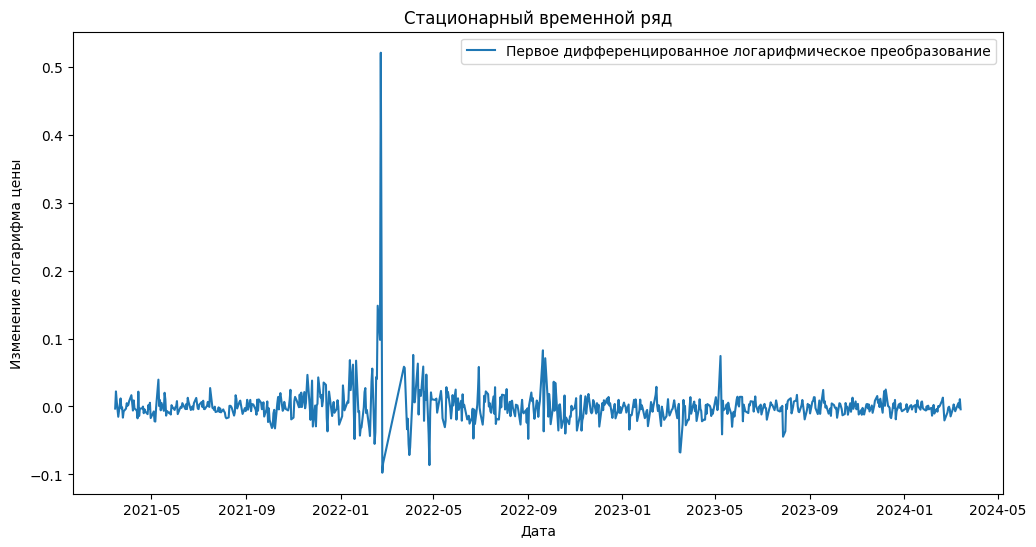

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Первое дифференцированное логарифмическое преобразование')
plt.title('Стационарный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Изменение логарифма цены')
plt.legend()
plt.show()

## Построение коррелограмм (ACF и PACF)

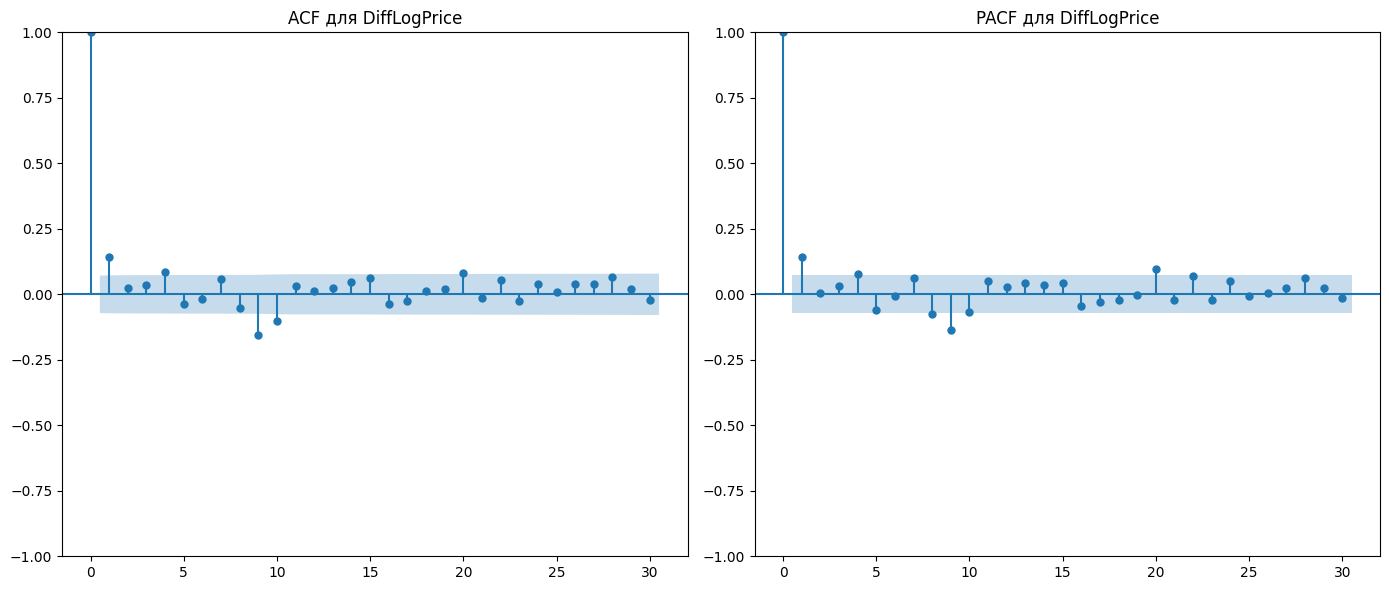

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=30, ax=plt.gca())
plt.title('ACF для DiffLogPrice')

plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF для DiffLogPrice')

plt.tight_layout()
plt.show()


### ACF

Первый лаг значительно выходит за доверительный интервал, что говорит о наличии автокорреляции на первом шаге.
Начиная со второго лага автокорреляция уже находится внутри доверительного интервала. Это указывает на то, что в преобразованном ряде влияние прошлого значения существенно только на один период назад.
Хвост ACF быстро затухает, что может свидетельствовать о том, что ряд стал стационарным и случайным.

### PACF (Partial Autocorrelation Function)

Первый лаг также значительно выше доверительного интервала, что подтверждает автокорреляцию первого порядка.
Остальные лаги уже незначимы, их значения находятся внутри доверительного интервала. Это может указывать на отсутствие более глубоких временных взаимосвязей.

In [31]:
# пусть обучающая выборка до 01.01.2024, тестовая с 01.01.2024 по 15.03.2024
train_end_date = '2024-01-01'

df_diff = df_diff.sort_index()
train = df_diff.loc[:train_end_date].copy()
test = df_diff.loc[train_end_date:].copy()

print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер обучающей выборки: (695,)
Размер тестовой выборки: (50,)


In [32]:
# Пробуем ARIMA(1,1,0)
model_110 = sm.tsa.ARIMA(train, order=(1,0,0))
res_110 = model_110.fit()
print("ARIMA(1,0,0) AIC:", res_110.aic)

# Пробуем ARIMA(0,1,1)
model_011 = sm.tsa.ARIMA(train, order=(0,0,1))
res_011 = model_011.fit()
print("ARIMA(0,0,1) AIC:", res_011.aic)

# Пробуем ARIMA(1,1,1)
model_111 = sm.tsa.ARIMA(train, order=(1,0,1))
res_111 = model_111.fit()
print("ARIMA(1,0,1) AIC:", res_111.aic)

ARIMA(1,0,0) AIC: -2998.544498374828
ARIMA(0,0,1) AIC: -2998.236659799808
ARIMA(1,0,1) AIC: -2996.5660055447506


Чем меньше значение AIC, тем лучше модель описывает данные при меньшем числе параметров. Модель ARIMA(1,0,0) имеет наименьшее значение AIC, что указывает на её наилучшее соответствие данным по сравнению с другими вариантами



Обучение

In [33]:
best_model = sm.tsa.ARIMA(train, order=(1,0,0))
best_model_fit = best_model.fit()
print(best_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:           DiffLogPrice   No. Observations:                  695
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1502.272
Date:                Sun, 23 Mar 2025   AIC                          -2998.544
Time:                        21:24:24   BIC                          -2984.913
Sample:                             0   HQIC                         -2993.273
                                - 695                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.338e-05      0.002      0.045      0.964      -0.004       0.004
ar.L1          0.1406      0.009     15.708      0.000       0.123       0.158
sigma2         0.0008   6.31e-06    122.936      0.0

<font color='red'>а прогнозы? </font>

# Оценка качества образования в области науки о данных
Для оценки качества образования по науке о данных можно использовать различные количественные индикаторы. Примеры таких индикаторов:

- Процент успешных выпускников — процент студентов, успешно завершивших программу обучения, сдавших все экзамены и получивших диплом
- Средний балл студентов — средняя оценка студентов за всю программу или по ключевым дисциплинам для Data Science (например, математике, программированию, статистике)
- Уровень трудоустройства выпускников — процент выпускников, трудоустроившихся в области науки о данных в течение 6 месяцев после завершения обучения
- Удовлетворенность студентов — средний рейтинг, который студенты дают курсу на основе опросов или анкетирования
- Процент преподавателей с профильным опытом — доля преподавателей, имеющих опыт работы в реальной сфере науки о данных


## Пример исследования
Цель исследования: выявить факторы, влияющие на качество образования по науке о данных в российских вузах

### Гипотезы исследования:
- Гипотеза 1: Наличие преподавателей с опытом работы в сфере Data Science влияет на успешность студентов (по показателю среднего балла)
- Гипотеза 2: Высокий уровень удовлетворенности студентов курсом и преподавателями влияет на трудоустройство выпускников
- Гипотеза 3: Студенты, получающие более высокие баллы в математике и программировании, имеют больший шанс трудоустроиться в области науки о данных

### Формирование выборки
Выборка будет включать студентов и выпускников российских вузов, обучающихся или обучавшихся на программах по науке о данных в течение последних 5 лет. Для оценки качества образования в рамках исследования будет использоваться стратифицированная случайная выборка, чтобы учесть различные типы вузов (государственные, частные, крупные и малые).

### Переменные для анализа
- Наличие преподавателей с практическим опытом в Data Science (категориальная переменная: "Да/Нет")
- Средний балл студентов (количественная переменная)
- Удовлетворенность студентов курсом (оценка от 1 до 5)
- Уровень трудоустройства выпускников (процент трудоустроенных в области наук о данных)
- Рейтинг преподавателей (оценка от 1 до 5)



### Методы анализа данных
#### Описательная статистика
Для всех переменных вычислить среднее, медиану, стандартное отклонение, минимальные и максимальные значения

#### Корреляционный анализ
Анализ корреляции между различными количественными переменными

#### Регрессионный анализ
Построение множественной линейной регрессии для изучения зависимости трудоустройства выпускников от факторов, таких как удовлетворенность курсом, наличие преподавателей с практическим опытом, средний балл и тп

#### Кластерный анализ
Разбиение студентов на различные группы



И потом сделать выводы, рекомендации к обучению